In [4]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import requests
import gzip
import re
import math
from datetime import datetime
from datetime import timedelta

### Calculate Hourly Production Cost 

In [41]:
pjm_df = pandas.read_csv('/home/amy/simple_dispatch/test/cems.csv')
fuel_price_df = pandas.read_csv('/home/amy/simple_dispatch/weekly/fuel_price.csv')
vom = pandas.read_csv('/home/amy/simple_dispatch/vom1.csv')

vom = vom[['orispl_unit', 'vom']]

# Remove PJM outliers 
pjm_df = pjm_df[(pjm_df.mwh >= 10.0) & (pjm_df.heat_rate <= 30.0)] 

fuel_price_2840 = fuel_price_df[fuel_price_df['orispl_unit'].isin(['2840_3'])]
fuel_price_2828 = fuel_price_df[fuel_price_df['orispl_unit'].isin(['2828_1'])]
fuel_price_593 = fuel_price_df[fuel_price_df['orispl_unit'].isin(['593_5'])]
pjm_df = pjm_df[pjm_df['orispl_unit'].isin(['2840_3', '2828_1', '593_5'])]

fuel_price_2840 = fuel_price_2840.drop(['Unnamed: 0', 'orispl_unit'], axis=1)
fuel_price_2840 = fuel_price_2840.T
fuel_price_2840['t'] = range(len(fuel_price_2840)) 
fuel_price_2840['t'] = fuel_price_2840['t'] + 1
fuel_price_2840['orispl_unit'] = '2840_3'

fuel_price_2828 = fuel_price_2828.drop(['Unnamed: 0', 'orispl_unit'], axis=1)
fuel_price_2828 = fuel_price_2828.T
fuel_price_2828['t'] = range(len(fuel_price_2828)) 
fuel_price_2828['t'] = fuel_price_2828['t'] + 1
fuel_price_2828['orispl_unit'] = '2828_1'

fuel_price_593 = fuel_price_593.drop(['Unnamed: 0', 'orispl_unit'], axis=1)
fuel_price_593 = fuel_price_593.T
fuel_price_593['t'] = range(len(fuel_price_593)) 
fuel_price_593['t'] = fuel_price_593['t'] + 1
fuel_price_593['orispl_unit'] = '593_5'

for df in [fuel_price_2840, fuel_price_2828, fuel_price_593]:
    df.columns = ['fuel_price', 't', 'orispl_unit']

fuel_price_df = pandas.concat([fuel_price_2840, fuel_price_2828, fuel_price_593], axis = 0)

temp = pandas.DataFrame(pjm_df.date.str.split('-').tolist(), columns=['month', 'day', 'year'], index=pjm_df.index).astype(float)
pjm_df['monthday'] = temp.year*10000 + temp.month*100 + temp.day

pjm_df['t'] = 52

for t in np.arange(52)+1:
    start = (datetime.strptime('2012-01-01', '%Y-%m-%d') + timedelta(days=7.05*(t-1)-1)).strftime('%Y-%m-%d') 
    end = (datetime.strptime('2012-01-01', '%Y-%m-%d') + timedelta(days=7.05*(t)-1)).strftime('%Y-%m-%d') 
    start_monthday = float(start[0:4])*10000 + float(start[5:7])*100 + float(start[8:])
    end_monthday = float(end[0:4])*10000 + float(end[5:7])*100 + float(end[8:])
    #slice the data for the days corresponding to the time series period, t
    pjm_df.loc[(pjm_df.monthday >= start_monthday) & (pjm_df.monthday < end_monthday), 't'] = t

# Merge the dfs 
df = pandas.merge(pjm_df, fuel_price_df, on=['orispl_unit', 't'], how='left')
df = pandas.merge(df, vom, on=['orispl_unit'], how='left')

df['fuel_cost'] = df['heat_rate'] * df['fuel_price']
df['vom_cost'] = df['vom'] * df['mwh']
df['production_cost'] = df['heat_rate'] * df['fuel_price'] + df['vom'] * df['mwh']

### Production Cost and Relationships 
heat rate * fuel price + variable operation and maintenance (estimated in $ / mwh) 

**Gas Plant**

In [42]:
gas = df[df['orispl_unit'].isin(['2840_3'])]

Heat Rate

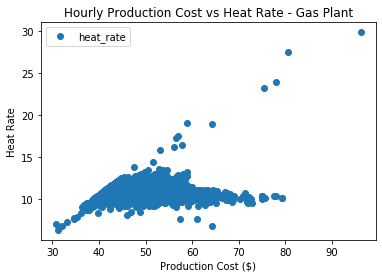

In [90]:
gas.plot(x='production_cost', y='heat_rate', style='o')  
plt.title('Hourly Production Cost vs Heat Rate - Gas Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('Heat Rate')

plt.show()

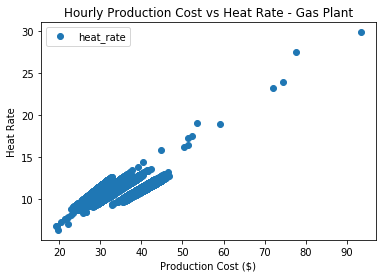

In [47]:
gas.plot(x='fuel_cost', y='heat_rate', style='o')  
plt.title('Hourly Fuel Cost vs Heat Rate - Gas Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('Heat Rate')

plt.show()

CO2 Emissions and Costs

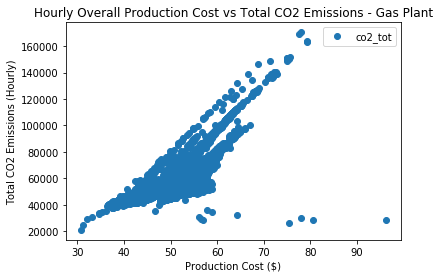

In [66]:
gas.plot(x='production_cost', y='co2_tot', style='o')  
plt.title('Hourly Overall Production Cost vs Total CO2 Emissions - Gas Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('Total CO2 Emissions (Hourly)')

plt.show()

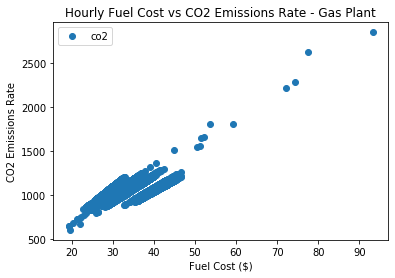

In [95]:
gas.plot(x='fuel_cost', y='co2', style='o')  
plt.title('Hourly Fuel Cost vs CO2 Emissions Rate - Gas Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('CO2 Emissions Rate')

plt.show()

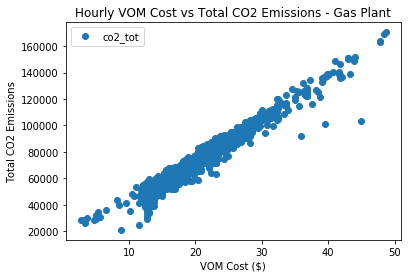

In [96]:
gas.plot(x='vom_cost', y='co2_tot', style='o')  
plt.title('Hourly VOM Cost vs Total CO2 Emissions - Gas Plant')  
plt.xlabel('VOM Cost ($)')
plt.ylabel('Total CO2 Emissions')

plt.show()

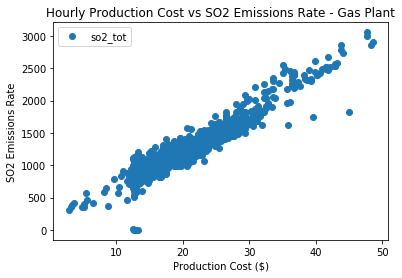

In [61]:
gas.plot(x='vom_cost', y='so2_tot', style='o')  
plt.title('Hourly VOM Cost vs Total SO2 Emissions - Gas Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('SO2 Emissions Rate')

plt.show()

Generation

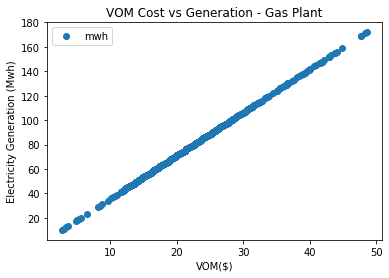

In [83]:
gas.plot(x='vom_cost', y='mwh', style='o')  
plt.title('VOM Cost vs Generation - Gas Plant')  
plt.xlabel('VOM($)')
plt.ylabel('Electricity Generation (Mwh)')

plt.show()

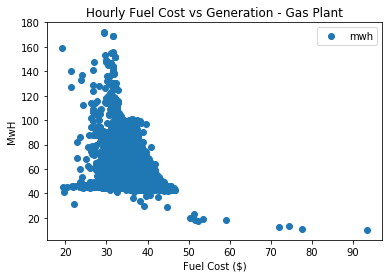

In [85]:
gas.plot(x='fuel_cost', y='mwh', style='o')  
plt.title('Hourly Fuel Cost vs Generation - Gas Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('MwH')

plt.show()

mmbtu

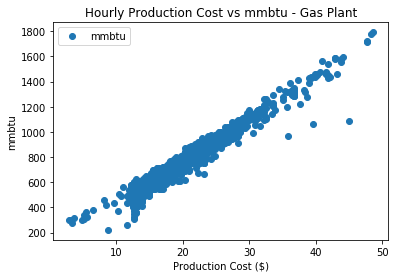

In [94]:
gas.plot(x='vom_cost', y='mmbtu', style='o')  
plt.title('Hourly Production Cost vs mmbtu - Gas Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('mmbtu')

plt.show()

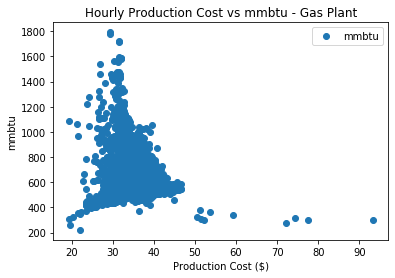

In [92]:
gas.plot(x='fuel_cost', y='mmbtu', style='o')  
plt.title('Hourly Fuel Cost vs mmbtu - Gas Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('mmbtu')

plt.show()

**Coal Plants**

Heat Rate

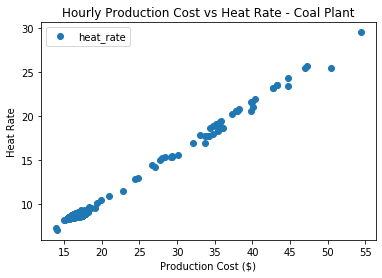

In [100]:
coal = df[df['orispl_unit'].isin(['2828_1'])]
coal.plot(x='fuel_cost', y='heat_rate', style='o')  
plt.title('Hourly Production Cost vs Heat Rate - Coal Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('Heat Rate')

plt.show()

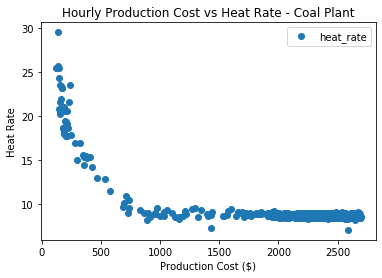

In [103]:
coal = df[df['orispl_unit'].isin(['2828_1'])]
coal.plot(x='vom_cost', y='heat_rate', style='o')  
plt.title('Hourly VOM Cost vs Heat Rate - Coal Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('Heat Rate')

plt.show()

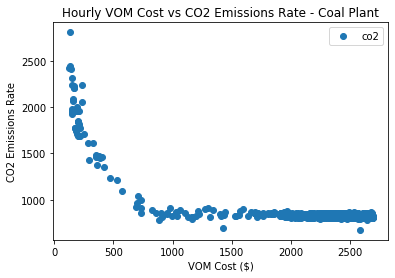

In [105]:
coal.plot(x='fuel_cost', y='co2', style='o')  
plt.title('Hourly VOM Cost vs CO2 Emissions Rate - Coal Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('CO2 Emissions Rate')

plt.show()

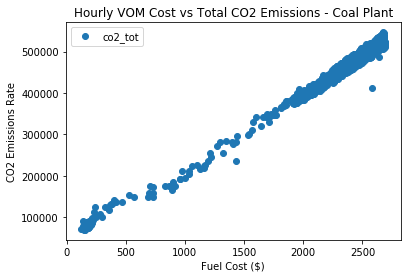

In [109]:
coal.plot(x='vom_cost', y='co2_tot', style='o')  
plt.title('Hourly VOM Cost vs Total CO2 Emissions - Coal Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('CO2 Emissions Rate')

plt.show()

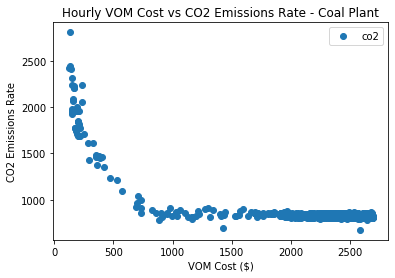

In [106]:
coal.plot(x='vom_cost', y='co2', style='o')  
plt.title('Hourly VOM Cost vs CO2 Emissions Rate - Coal Plant')  
plt.xlabel('VOM Cost ($)')
plt.ylabel('CO2 Emissions Rate')

plt.show()

Energy Generation

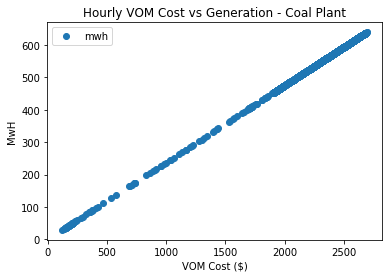

In [117]:
coal.plot(x='vom_cost', y='mwh', style='o')  
plt.title('Hourly VOM Cost vs Generation - Coal Plant')  
plt.xlabel('VOM Cost ($)')
plt.ylabel('MwH')

plt.show()

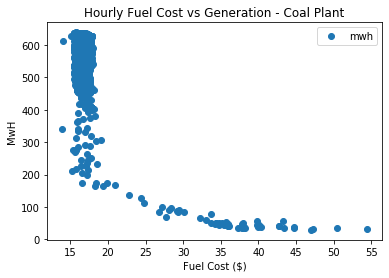

In [118]:
coal.plot(x='fuel_cost', y='mwh', style='o')  
plt.title('Hourly Fuel Cost vs Generation - Coal Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('MwH')

plt.show()

mmbtu

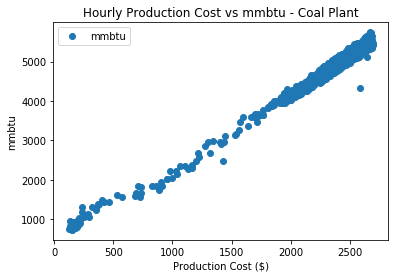

In [122]:
coal.plot(x='vom_cost', y='mmbtu', style='o')  
plt.title('Hourly Production Cost vs mmbtu - Coal Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('mmbtu')

plt.show()

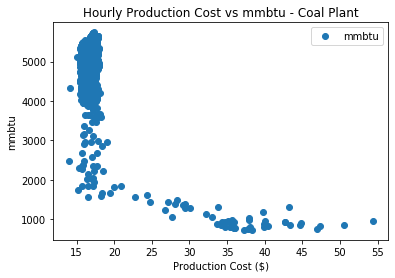

In [121]:
coal.plot(x='fuel_cost', y='mmbtu', style='o')  
plt.title('Hourly Production Cost vs mmbtu - Coal Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('mmbtu')

plt.show()

**Oil Plant**

In [123]:
oil = df[df['orispl_unit'].isin(['593_5'])]

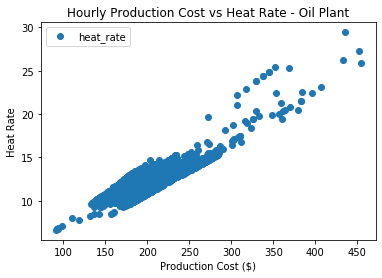

In [124]:
oil.plot(x='fuel_cost', y='heat_rate', style='o')  
plt.title('Hourly Fuel Cost vs Heat Rate - Oil Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('Heat Rate')

plt.show()

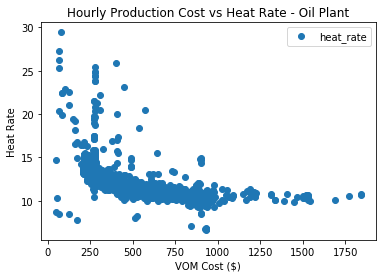

In [127]:
oil.plot(x='vom_cost', y='heat_rate', style='o')  
plt.title('Hourly Production Cost vs Heat Rate - Oil Plant')  
plt.xlabel('VOM Cost ($)')
plt.ylabel('Heat Rate')

plt.show()

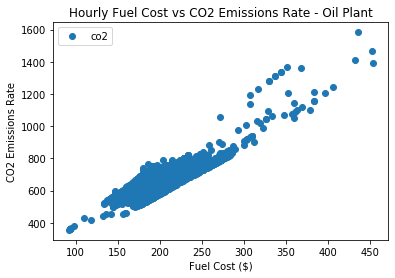

In [129]:
oil.plot(x='fuel_cost', y='co2', style='o')  
plt.title('Hourly Fuel Cost vs CO2 Emissions Rate - Oil Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('CO2 Emissions Rate')

plt.show()

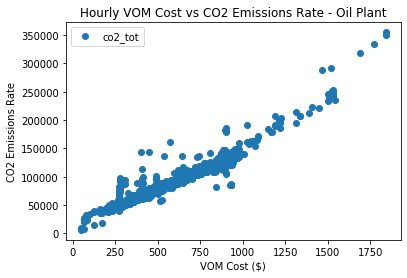

In [136]:
oil.plot(x='vom_cost', y='co2_tot', style='o')  
plt.title('Hourly VOM Cost vs CO2 Emissions Rate - Oil Plant')  
plt.xlabel('VOM Cost ($)')
plt.ylabel('CO2 Emissions Rate')

plt.show()

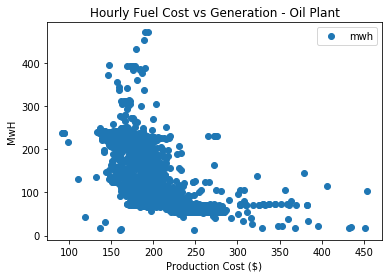

In [134]:
oil.plot(x='fuel_cost', y='mwh', style='o')  
plt.title('Hourly Fuel Cost vs Generation - Oil Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('MwH')

plt.show()

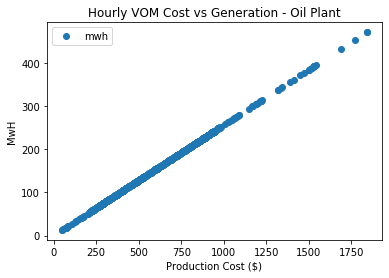

In [135]:
oil.plot(x='vom_cost', y='mwh', style='o')  
plt.title('Hourly VOM Cost vs Generation - Oil Plant')  
plt.xlabel('Production Cost ($)')
plt.ylabel('MwH')

plt.show()

mmbtu

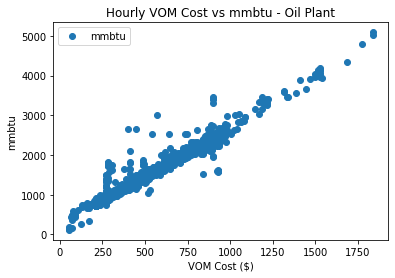

In [141]:
oil.plot(x='vom_cost', y='mmbtu', style='o')  
plt.title('Hourly VOM Cost vs mmbtu - Oil Plant')  
plt.xlabel('VOM Cost ($)')
plt.ylabel('mmbtu')

plt.show()

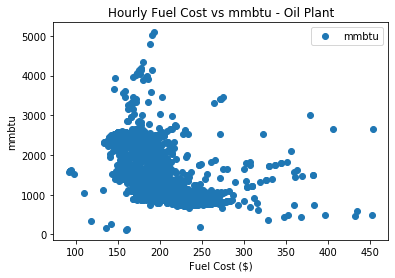

In [140]:
oil.plot(x='fuel_cost', y='mmbtu', style='o')  
plt.title('Hourly Fuel Cost vs mmbtu - Oil Plant')  
plt.xlabel('Fuel Cost ($)')
plt.ylabel('mmbtu')

plt.show()